# **Taller Clustering con LDA**

**Estudiante: Francisco Salamanca**

**Mineria de datos: Universidad Nacional de Colombia**

**2025-1**

----

## **Sección 1**

### **Que es LDA? , Cuales son sus Aplicaciones?**

LDA: Latent Dirichlet Allocation (LDA), En procesamiento de lenguaje natural (NLP) Es un modelo generativo probabilístico que se usa para descubrir temas ocultos (topics) en un conjunto de documentos.


- Genera clusters suaves (mezcla de diferentes topics) teniendo en cuenta las palabras, el parametro de entrada es el numero de clusters a obtener.

- Palabras que aparecen frecuentemente juntas en los mismos documentos, tienden a ser agrupadas en el mismo tema. (patrones de coocurrencia).



### **LDA de tipo SKP (Sentiment Knowledge Pair)**



#### - **Ventajas de LDA:**
- La asignacion de grupos de hace probalisticamente.
- El modelo generativo es bayesiano (no usa geometria o densidad)
- Datos discretos como inputs
- Provee una didtribucion de temas por documento, no asigna un cluster unico

- Prermite mezcla de temas, si el problema reconoce que los objetos (palabras) pueden pertenecer parcialmente a varios grupos
- Realista en datos biologicos, (los procesos no suelen ser excluyentes)
- Al ser un modelo probbilistico, la salida sirve cono entrada para modelos posteriores, (NN, COX)

#### - **Cuando usar clusters normales:**

Si se tienen datos continuos, si se quiere un analisis descriptivo o exploratorio.


#### - **Aplicaciones:**

- Análisis de opinión pública

- Marketing digital y reputación

- Detección de tendencias sociales

- Apoyo en políticas públicas

- Detectar Subtipos Moleculares, procesos biológicos latentes, firmas proteicas, subpoblaciones de pacientes.

- Reduccion de dimensionalidad (Vector con numero de temas)

- Analisis longitudinal





#### - **Ejemplo, Posible aproximación:**

Detectar 5-10 firmas proteomicas latentes (temas),

- ver que firma predomina en en mpacientes con IBD?
- cual predice necesdad de cirugia? LDA + regresion de supervivencia
- Cual tiene assoc a ciertos SNPs o farmacos? LDA + Reg. multiple

- Se puede usar LDA para obtener temas y luego clustering sobre los vectores de los temas





In [4]:
# Cargar drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
# Paquete para modelamiento de topicos (NLP)
!pip install gensim

Puede que se genere un error al usar el comando !pip install gensim, pero no se le debe dar importancia, la librería funciona sin ningún problema

In [2]:
# Natural Lenguage Toolkit
!pip install nltk scikit-learn

In [3]:
import pandas as pd
import numpy as np
import re
from gensim.utils import simple_preprocess

### Limpieza de datos
El objetivo de este análisis es realizar un modelado temático, vamos a centrarnos sólo en los datos de texto de cada artículo, y dejaremos de lado otras columnas de metadatos.

In [5]:
alibaba_df = pd.read_csv('/content/drive/MyDrive/Bioinformatica Msc. - UNAL/Data Mining/Talller_Clustering_LDA/Alibaba.csv', nrows=1000)
alibaba_df.head()

,reviewId,content,score,thumbsUpCount,at,replyContent,repliedAt,appName
0,275f465b-a58b-439e-ae7c-f9f6dcf2634d,Trying to use the on website is almost impossi...,1,39,1720995717000,"Hi, we are sorry to hear that. Do share additi...",1.721048e+12,Alibaba
1,e6c13852-277e-451a-b8d5-dd92aea75402,Had to uninstall due to the amount of notifica...,3,60,1720501958000,"Hi, we are sorry to hear that. Do share additi...",1.721051e+12,Alibaba
2,254b3705-c54b-4ce4-8982-5b468d38231d,I order and it takes too long the shpping days...,1,7,1721866371000,NaN,NaN,Alibaba
3,c83c1e64-6aa3-42e8-9a56-0385a297b87b,Buyer beware! They have tons of listings that ...,1,2301,1611569460000,NaN,NaN,Alibaba
4,7a65dce8-3f09-4e4e-a263-55efebc13c65,It's all around a great app except for the fac...,4,1859,1545438323000,Thanks for your feedback. Could you tell us mo...,1.515586e+12,Alibaba


In [6]:
# Columnas a eliminar
columnas_a_eliminar = ['reviewId', 'thumbsUpCount', 'repliedAt','at','appName'] #Eliminar las columnas que considere necesarias
alibaba_df = alibaba_df.drop(columns=columnas_a_eliminar, errors='ignore')
alibaba_df.head()

,content,score,replyContent
0,Trying to use the on website is almost impossi...,1,"Hi, we are sorry to hear that. Do share additi..."
1,Had to uninstall due to the amount of notifica...,3,"Hi, we are sorry to hear that. Do share additi..."
2,I order and it takes too long the shpping days...,1,NaN
3,Buyer beware! They have tons of listings that ...,1,NaN
4,It's all around a great app except for the fac...,4,Thanks for your feedback. Could you tell us mo...


Preprocesamiento en el contenido de la columna content para hacerlos más susceptibles de análisis y obtener resultados fiables.

In [7]:
# Preprocesar texto para Alibaba
alibaba_df['text_processed'] = alibaba_df['content'].map(lambda x: re.sub('[,\.!?]', '', x))
alibaba_df['text_processed'] = alibaba_df['text_processed'].map(lambda x: x.lower())
print("\nPrimeras filas de Alibaba procesadas:")
print(alibaba_df['text_processed'].head())


Primeras filas de Alibaba procesadas:
0    trying to use the on website is almost impossi...
1    had to uninstall due to the amount of notifica...
2    i order and it takes too long the shpping days...
3    buyer beware they have tons of listings that a...
4    it's all around a great app except for the fac...
Name: text_processed, dtype: object


### Análisis exploratorio

In [33]:
from wordcloud import WordCloud

# Une los distintos títulos procesados.
long_string = ','.join(list(alibaba_df['text_processed'].values))

# Crear un objeto WordCloud
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', width=800, height=400) # Increased width and height

# Generar una nube de palabras, de tamano
wordcloud.generate(long_string)
wordcloud.to_image()

### Preparar los datos para el análisis LDA
Transformar los datos textuales en un formato que sirva de entrada para el entrenamiento del modelo LDA. Empezamos por tokenizar el texto y eliminar las stopwords. A continuación, convertimos el objeto tokenizado en un corpus y un diccionario.

In [12]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]

data = alibaba_df.text_processed.values.tolist()
data_words = list(sent_to_words(data))

# Eliminar palabras vacías
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['trying', 'use', 'website', 'almost', 'impossible', 'due', 'app', 'store', 'pop', 'everytime', 'click', 'product', 'details', 'pop', 'install', 'app', 'comes', 'click', 'click', 'back', 'continue', 'site', 'sends', 'back', 'homepage', 'unfortunate', 'really', 'want', 'use', 'website']


In [13]:
import gensim.corpora as corpora

# Crear diccionario
id2word = corpora.Dictionary(data_words)

# Crear Corpus
texts = data_words

# Término Frecuencia de documentos
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1][0][:30])

[(0, 1), (1, 2), (2, 2), (3, 1), (4, 3), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 2)]


### Entrenamiento del modelo LDA
Modelo con x topics donde cada tema es una combinación de palabras clave, y cada palabra clave contribuye con un cierto peso al tema.

In [19]:
from pprint import pprint
import gensim

# numero de topics
num_topics = 10 # Modificar x

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.017*"app" + 0.016*"order" + 0.011*"prices" + 0.009*"good" + 0.008*"like" '
  '+ 0.008*"great" + 0.007*"items" + 0.007*"shipping" + 0.007*"alibaba" + '
  '0.007*"get"'),
 (1,
  '0.037*"app" + 0.014*"products" + 0.011*"good" + 0.010*"easy" + 0.009*"like" '
  '+ 0.007*"shipping" + 0.006*"time" + 0.006*"use" + 0.006*"great" + '
  '0.005*"find"'),
 (2,
  '0.019*"app" + 0.013*"products" + 0.009*"alibaba" + 0.008*"never" + '
  '0.008*"good" + 0.007*"buy" + 0.007*"get" + 0.007*"service" + 0.006*"prices" '
  '+ 0.006*"excellent"'),
 (3,
  '0.027*"app" + 0.023*"good" + 0.012*"price" + 0.010*"shipping" + '
  '0.009*"order" + 0.008*"product" + 0.007*"easy" + 0.007*"alibaba" + '
  '0.007*"also" + 0.007*"use"'),
 (4,
  '0.043*"app" + 0.010*"time" + 0.008*"phone" + 0.008*"alibaba" + 0.008*"good" '
  '+ 0.008*"great" + 0.008*"shipping" + 0.007*"like" + 0.006*"get" + '
  '0.006*"also"'),
 (5,
  '0.019*"app" + 0.011*"items" + 0.010*"good" + 0.009*"get" + 0.008*"buy" + '
  '0.007*"application" 

In [15]:
# Función para mostrar las n palabras clave principales de cada temaObtener el tema principal de cada documento
def format_topics_sentences(ldamodel, corpus, texts):

    sent_topics_df = pd.DataFrame()

    # Obtener el tema principal de cada documento
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Obtener el tema dominante, la contribución porcentual y las palabras clave de cada documento.
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => topic dominante
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = pd.concat([sent_topics_df,
                                           pd.DataFrame([[int(topic_num), round(prop_topic,4), topic_keywords]],
                                                      columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])],
                                           ignore_index=True)
            else:
                break
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words)

# Formato
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']


print(df_dominant_topic.head(10))

# Agrupar por tema dominante y obtener el número de documentos de cada topic
topic_counts = df_dominant_topic['Dominant_Topic'].value_counts().reset_index()
topic_counts.columns = ['Dominant_Topic', 'Num_Documents']
print("\nNumber of documents per dominant topic:")
print(topic_counts)

# Mostrar los documentos más importantes de un tema específico (Topic 0)
print("\nTop documents for Topic 0:")
print(df_dominant_topic.loc[df_dominant_topic['Dominant_Topic'] == 0].head())

   Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0               1              0.9727   
1            1               2              0.9763   
2            2               1              0.9775   
3            3               2              0.5083   
4            4               8              0.9757   
5            5               1              0.9690   
6            6               7              0.6506   
7            7               3              0.9757   
8            8               2              0.9775   
9            9               1              0.4901   

                                            Keywords  \
0  app, good, products, product, buy, alibaba, on...   
1  app, alibaba, like, good, time, even, items, o...   
2  app, good, products, product, buy, alibaba, on...   
3  app, alibaba, like, good, time, even, items, o...   
4  app, product, like, love, items, time, get, sh...   
5  app, good, products, product, buy, alibaba, on...   
6  alibaba, p

### Ejercicio 1
*   Modificar el número de topics y comparar resultados con 2 diferentes topics
*   ¿Qué se puede concluir al comparar los resultados?

In [22]:
from pprint import pprint
import gensim


# numero de topics
num_topics_1 = 5
num_topics_2 = 15

# Build LDA model
print(f"Entrenamiento del modelo con {num_topics_1} topics:")
lda_model_1 = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics_1)# Print the Keyword in the 5 topics
pprint(lda_model_1.print_topics())
doc_lda_1 = lda_model_1[corpus]


print(" ")

print(f"Entrenamiento del modelo con {num_topics_2} topics:")
lda_model_2 = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics_2)# Print the Keyword in the 15 topics
pprint(lda_model_2.print_topics())
doc_lda_2 = lda_model_2[corpus]


Entrenamiento del modelo con 5 topics:


[(0,
  '0.024*"app" + 0.010*"good" + 0.010*"order" + 0.008*"product" + 0.008*"like" '
  '+ 0.007*"also" + 0.007*"price" + 0.007*"would" + 0.007*"great" + '
  '0.006*"shipping"'),
 (1,
  '0.026*"app" + 0.010*"get" + 0.007*"great" + 0.006*"shipping" + '
  '0.006*"products" + 0.006*"price" + 0.006*"items" + 0.006*"alibaba" + '
  '0.005*"one" + 0.005*"phone"'),
 (2,
  '0.035*"app" + 0.011*"alibaba" + 0.008*"like" + 0.008*"time" + 0.008*"order" '
  '+ 0.007*"easy" + 0.007*"use" + 0.007*"want" + 0.007*"good" + 0.007*"get"'),
 (3,
  '0.026*"app" + 0.010*"good" + 0.009*"like" + 0.008*"items" + 0.007*"great" + '
  '0.006*"notifications" + 0.006*"one" + 0.006*"item" + 0.006*"price" + '
  '0.005*"get"'),
 (4,
  '0.029*"app" + 0.016*"products" + 0.015*"good" + 0.010*"like" + 0.010*"time" '
  '+ 0.009*"alibaba" + 0.008*"shipping" + 0.006*"product" + 0.006*"find" + '
  '0.006*"buy"')]
 
Entrenamiento del modelo con 15 topics:
[(0,
  '0.032*"app" + 0.013*"good" + 0.012*"get" + 0.008*"product" + '
  '

R/ Los grupos creados con una cantidad de topics menor, son mucho mas generalizados. Mientras que al tener un alto numero de topics, los clusters creados son mas especializados.

## **Sección 2**
### **Crear y entrenar el clusterer**

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score, accuracy_score, f1_score

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from collections import defaultdict
import gensim.corpora as corpora
from gensim import models
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

class LDACoOccurrenceClusterer:
    def __init__(self, num_topics=5, window_size=2):
        """
        Inicializa el clusterizador LDA con co-ocurrencia

        Args:
            num_topics (int): Número de tópicos para LDA
            window_size (int): Tamaño de la ventana para co-ocurrencia
        """
        self.num_topics = num_topics
        self.window_size = window_size
        # Use stop_words from the previous cell
        self.stop_words = stop_words
        self.vectorizer = CountVectorizer(max_df=0.95, min_df=2)
        self.lda_model = None
        self.co_occurrence_matrix = None
        self.vocab_list = None # Store vocab_list

    def preprocess_text(self, texts):
        """
        Preprocesa los textos eliminando stopwords y tokenizando

        Args:
            texts (list): Lista de textos a procesar

        Returns:
            list: Lista de textos procesados
        """
        processed_texts = []
        for text in texts:
            # Assuming text is already tokenized list of words from previous steps
            tokens = [t for t in text if t not in self.stop_words and t.isalnum()]
            processed_texts.append(' '.join(tokens))
        return processed_texts

    def build_co_occurrence_matrix(self, texts):
        """
        Construye la matriz de co-ocurrencia de palabras

        Args:
            texts (list): Lista de texts (joined words) processed by preprocess_text
        """
        word_pairs = defaultdict(int)
        vocabulary = set()

        for text in texts:
            words = text.split()
            vocabulary.update(words)

            for i in range(len(words)):
                for j in range(max(0, i - self.window_size), min(len(words), i + self.window_size + 1)):
                    if i != j:
                        # Ensure consistent order for the pair
                        pair = tuple(sorted((words[i], words[j])))
                        word_pairs[pair] += 1

        # Convertir a matriz
        self.vocab_list = sorted(list(vocabulary)) # Store vocab_list
        self.co_occurrence_matrix = np.zeros((len(self.vocab_list), len(self.vocab_list)))

        for (w1, w2), count in word_pairs.items():
            if w1 in self.vocab_list and w2 in self.vocab_list: # Check if words are in vocab_list
                i = self.vocab_list.index(w1)
                j = self.vocab_list.index(w2)
                self.co_occurrence_matrix[i, j] = count


    def fit(self, texts):
        """
        Entrena el modelo LDA con características de co-ocurrencia

        Args:
            texts (list): Lista of original texts (list of words) to cluster
        """
        # Preprocesar textos
        # texts here are expected to be the output of the previous processing step (list of lists of words)
        processed_texts_joined = self.preprocess_text([' '.join(text) for text in texts])


        # Construir matriz de co-ocurrencia
        self.build_co_occurrence_matrix(processed_texts_joined)

        # Prepare documents for LDA - use the original tokenized texts
        dictionary = corpora.Dictionary(texts)
        corpus = [dictionary.doc2bow(text) for text in texts]

        # Entrenar modelo LDA
        self.lda_model = models.LdaModel(
            corpus=corpus,
            num_topics=self.num_topics,
            id2word=dictionary,
            passes=10
        )

    def get_topics(self, num_words=5):
        """
        Obtiene los tópicos principales

        Args:
            num_words (int): Número de palabras por tópico

        Returns:
            list: Lista de tópicos con sus palabras principales
        """
        if self.lda_model is None:
            raise ValueError("El modelo debe ser entrenado primero")

        topics = []
        for topic_id in range(self.num_topics):
            topic_words = self.lda_model.show_topic(topic_id, num_words)
            topics.append([word for word, _ in topic_words])
        return topics

    def visualize_topics(self):
        """
        Visualiza los tópicos usando wordclouds
        """
        if self.lda_model is None:
            raise ValueError("El modelo debe ser entrenado primero")

        fig, axes = plt.subplots(1, self.num_topics, figsize=(15, 5))
        if self.num_topics == 1:
            axes = [axes]

        for i, ax in enumerate(axes):
            topic_words = dict(self.lda_model.show_topic(i, 20))
            wordcloud = WordCloud(width=400, height=400,
                                background_color='white',
                                max_words=100).generate_from_frequencies(topic_words)
            ax.imshow(wordcloud, interpolation='bilinear')
            ax.set_title(f'Tópico {i+1}')
            ax.axis('off')

        plt.tight_layout()
        plt.show()

    def visualize_co_occurrence(self, top_n=10):
        """
        Visualiza la matriz de co-ocurrencia para las palabras más frecuentes

        Args:
            top_n (int): Número de palabras más frecuentes a mostrar
        """
        if self.co_occurrence_matrix is None or self.vocab_list is None:
            raise ValueError("La matriz de co-ocurrencia y la lista de vocabulario deben ser construidas primero")

        # Obtener las palabras más frecuentes (based on total co-occurrence count)
        word_co_occurrence_counts = np.sum(self.co_occurrence_matrix, axis=1) + np.sum(self.co_occurrence_matrix, axis=0)
        top_indices = np.argsort(word_co_occurrence_counts)[-top_n:]

        top_words = [self.vocab_list[i] for i in top_indices]

        # Crear submatriz para las palabras más frecuentes
        sub_matrix = self.co_occurrence_matrix[top_indices][:, top_indices]

        plt.figure(figsize=(10, 8))
        sns.heatmap(sub_matrix,
                   cmap='YlOrRd',
                   square=True,
                   annot=True,
                   fmt='.0f',
                   xticklabels=top_words,
                   yticklabels=top_words)
        plt.title('Matriz de Co-ocurrencia de Palabras')
        plt.show()

    def visualize_topic_distribution(self, texts):
        """
        Visualiza la distribución de tópicos para los documentos

        Args:
            texts (list): Lista of original texts (list of words)
        """
        if self.lda_model is None:
            raise ValueError("El modelo debe ser entrenado primero")

        # Obtener distribución de tópicos para cada documento
        # Use the original tokenized texts for creating the corpus
        dictionary = corpora.Dictionary(texts)
        corpus = [dictionary.doc2bow(text) for text in texts]

        topic_distributions = []
        for doc in corpus:
            topic_dist = self.lda_model.get_document_topics(doc)
            # Garantizar que todos los temas estén representados
            dist = [0] * self.num_topics
            for topic_id, prob in topic_dist:
                dist[topic_id] = prob
            topic_distributions.append(dist)


        # Convertir a DataFrame para visualización
        df = pd.DataFrame(topic_distributions,
                         columns=[f'Tópico {i+1}' for i in range(self.num_topics)])

        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df)
        plt.title('Distribución de Tópicos en los Documentos')
        plt.ylabel('Probabilidad')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


Tópicos encontrados:
Tópico 1: la, minería, de, el, es
Tópico 2: requiere, minerales, de, capacitación, trabajadores
Tópico 3: en, es, la, minería, minas

Generando visualizaciones...


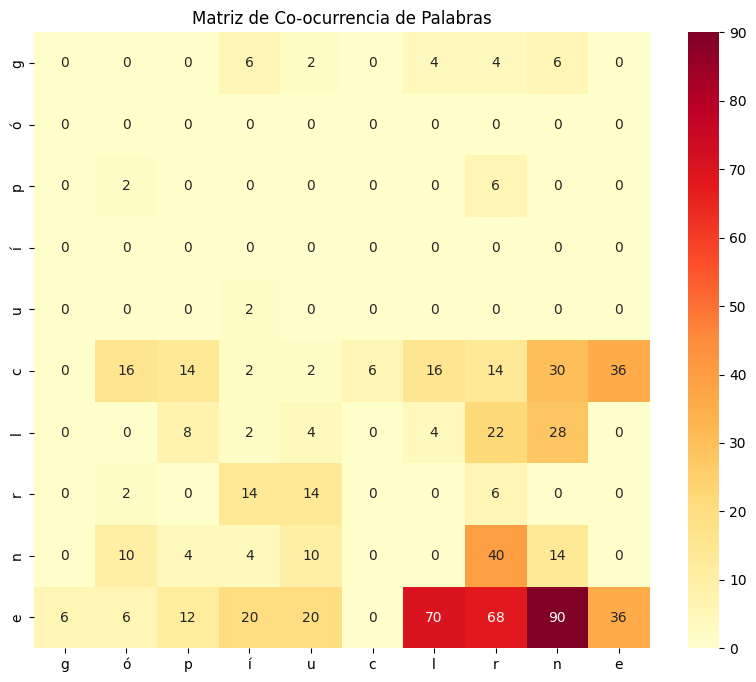

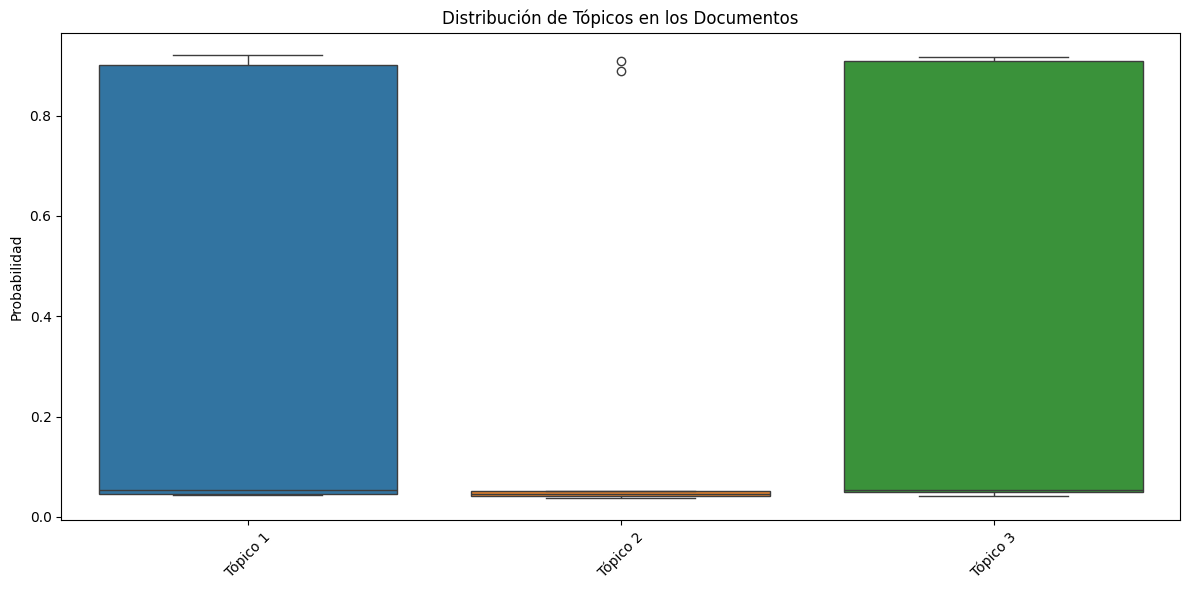

In [25]:
from gensim.utils import simple_preprocess

textos_ejemplo = [
        "La minería es una actividad económica importante",
        "La extracción de minerales requiere tecnología avanzada",
        "El impacto ambiental de la minería es significativo",
        "La seguridad en las minas es fundamental",
        "La minería genera empleo en zonas rurales",
        "El procesamiento de minerales es complejo",
        "La minería requiere inversión en maquinaria",
        "Los trabajadores mineros necesitan capacitación",
        "La minería contribuye al desarrollo económico",
        "El control de calidad es esencial en minería"
    ]

# Tokenizar los textos de ejemplo
tokenized_textos_ejemplo = [simple_preprocess(text) for text in textos_ejemplo]

# Números de tópicos
clusterer = LDACoOccurrenceClusterer(num_topics=3)
clusterer.fit(tokenized_textos_ejemplo) # Pasar textos tokenizados para que encajen

# Evaluación de resultados
print("\nTópicos encontrados:")
for i, topic in enumerate(clusterer.get_topics()):
    print(f"Tópico {i+1}: {', '.join(topic)}")

print("\nGenerando visualizaciones...")
clusterer.visualize_co_occurrence()
clusterer.visualize_topic_distribution(tokenized_textos_ejemplo) # Pass tokenized texts to visualize_topic_distribution

### Ejercicio 2
Crear y entrenar el clusterer con los datos de data_words obtenidos a partir del archivo Alibaba.csv
*    Experimentar con diferentes números de tópicos x
*    ¿Qué se puede concluir al comparar los resultados con diferentes tópicos?


Tópicos encontrados:
Tópico 1: app, notifications, products, time, alibaba
Tópico 2: app, good, like, alibaba, get

Generando visualizaciones...


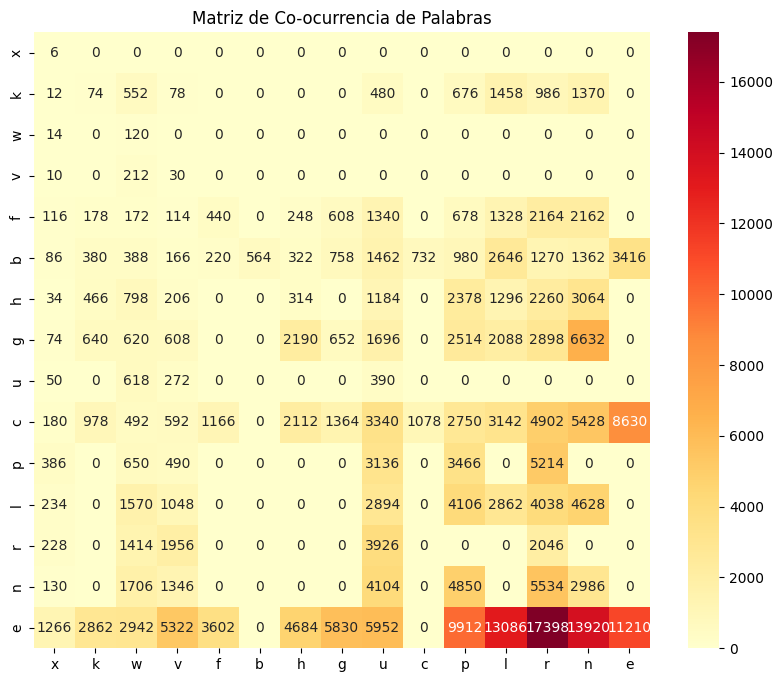

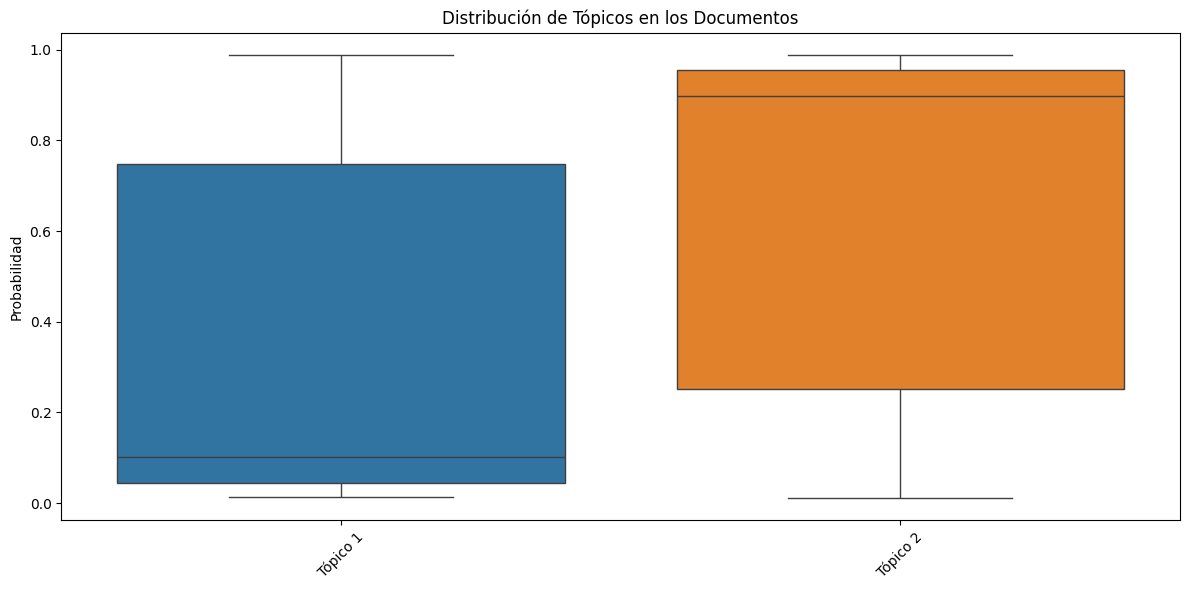

In [30]:
clusterer = LDACoOccurrenceClusterer(num_topics=2) # Experimentar con diferentes números de tópicos x
clusterer.fit(data_words)

print("\nTópicos encontrados:")
for i, topic in enumerate(clusterer.get_topics()):
    print(f"Tópico {i+1}: {', '.join(topic)}")

print("\nGenerando visualizaciones...")
clusterer.visualize_co_occurrence(top_n=15) # Increased top_n for better visualization
clusterer.visualize_topic_distribution(data_words)


Tópicos encontrados con num_topics=4:
Tópico 1: app, get, like, time, order
Tópico 2: app, alibaba, great, phone, one
Tópico 3: app, good, buy, shipping, one
Tópico 4: app, easy, use, service, customer
Tópico 5: app, products, like, alibaba, good

Generando visualizaciones para num_topics=4...


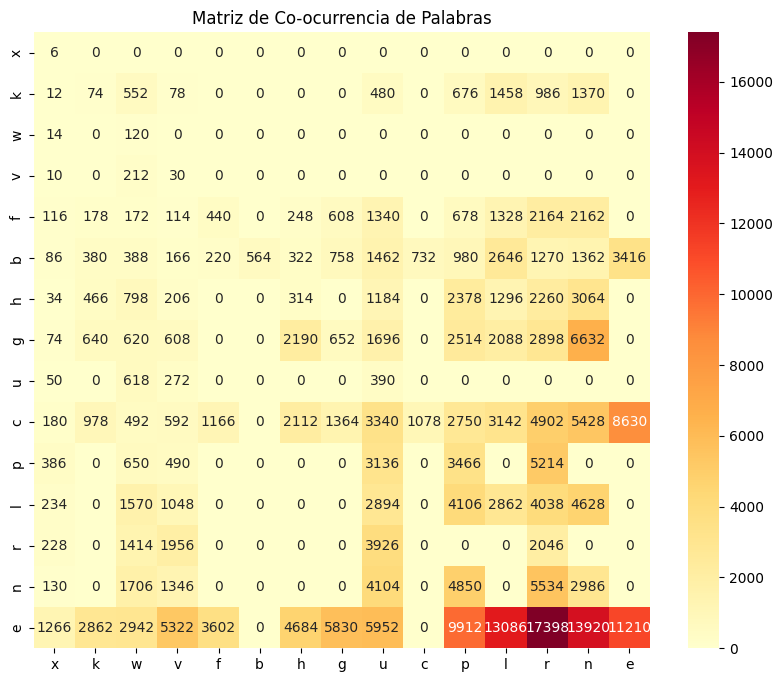

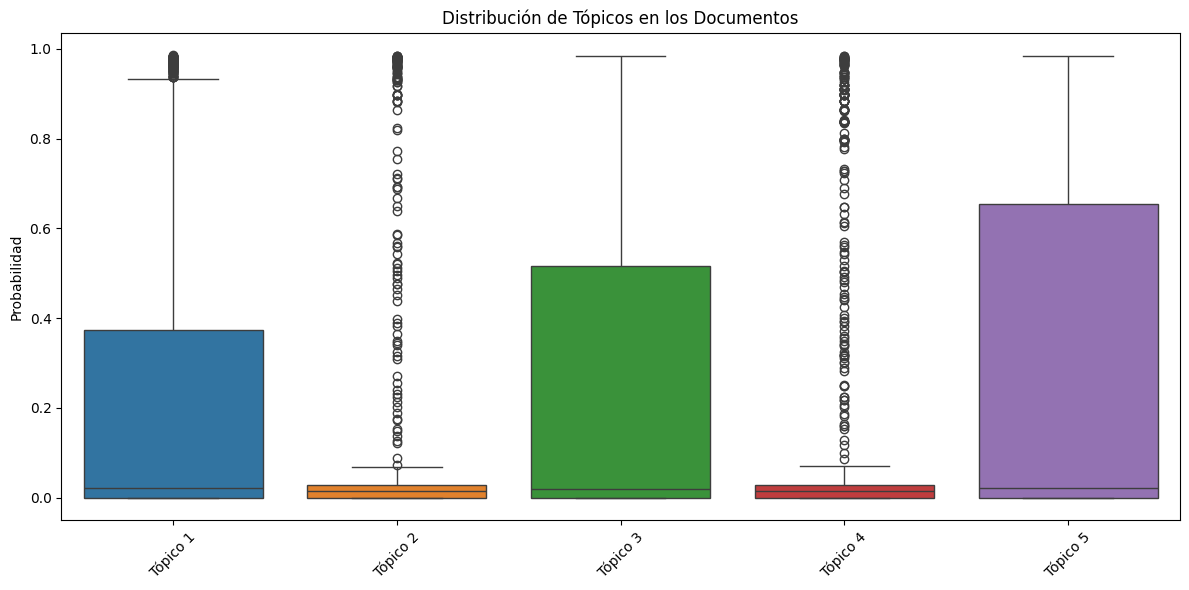

In [32]:
clusterer_4_topics = LDACoOccurrenceClusterer(num_topics=5)
clusterer_4_topics.fit(data_words)

print("\nTópicos encontrados con num_topics=4:")
for i, topic in enumerate(clusterer_4_topics.get_topics()):
    print(f"Tópico {i+1}: {', '.join(topic)}")

print("\nGenerando visualizaciones para num_topics=4...")
clusterer_4_topics.visualize_co_occurrence(top_n=15)
clusterer_4_topics.visualize_topic_distribution(data_words)


Tópicos encontrados:
Tópico 1: app, alibaba, order, easy, shopping
Tópico 2: app, get, products, good, best
Tópico 3: app, products, like, shipping, one
Tópico 4: app, great, good, would, want
Tópico 5: app, shipping, alibaba, make, one
Tópico 6: good, app, prices, products, service
Tópico 7: app, like, good, phone, great
Tópico 8: good, app, buy, stuff, know

Generando visualizaciones...


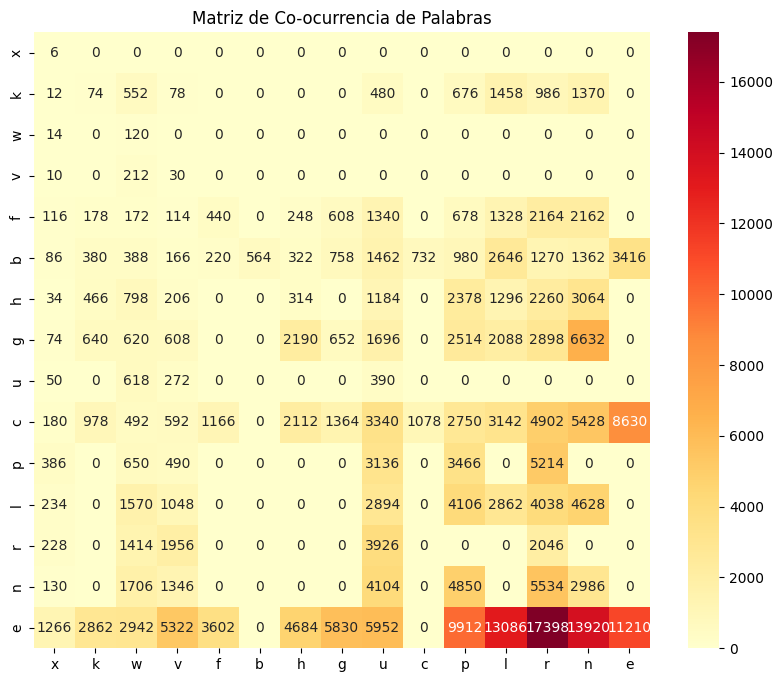

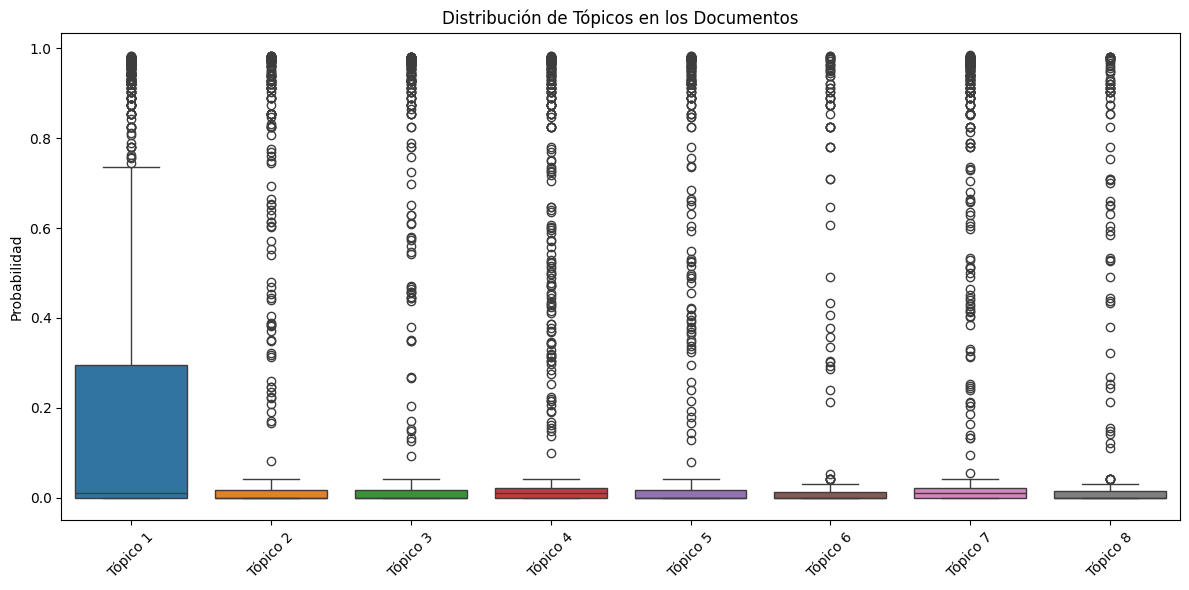

In [31]:
clusterer = LDACoOccurrenceClusterer(num_topics=8) # Experimentar con diferentes números de tópicos x
clusterer.fit(data_words)

print("\nTópicos encontrados:")
for i, topic in enumerate(clusterer.get_topics()):
    print(f"Tópico {i+1}: {', '.join(topic)}")

print("\nGenerando visualizaciones...")
clusterer.visualize_co_occurrence(top_n=15) # Increased top_n for better visualization
clusterer.visualize_topic_distribution(data_words)


Tópicos encontrados:
Tópico 1: app, one, get, like, good
Tópico 2: like, price, order, app, time
Tópico 3: app, shipping, good, buy, prices
Tópico 4: products, order, great, good, items
Tópico 5: app, like, product, costs, price
Tópico 6: app, please, time, alibaba, would
Tópico 7: app, easy, love, use, best
Tópico 8: reliable, product, best, ever, far
Tópico 9: alibaba, app, products, product, find
Tópico 10: app, alibaba, good, phone, like
Tópico 11: app, one, alibaba, get, like
Tópico 12: app, payment, customer, alibaba, make
Tópico 13: good, order, app, like, easy
Tópico 14: app, phone, like, everything, notifications
Tópico 15: app, great, notifications, even, good

Generando visualizaciones...


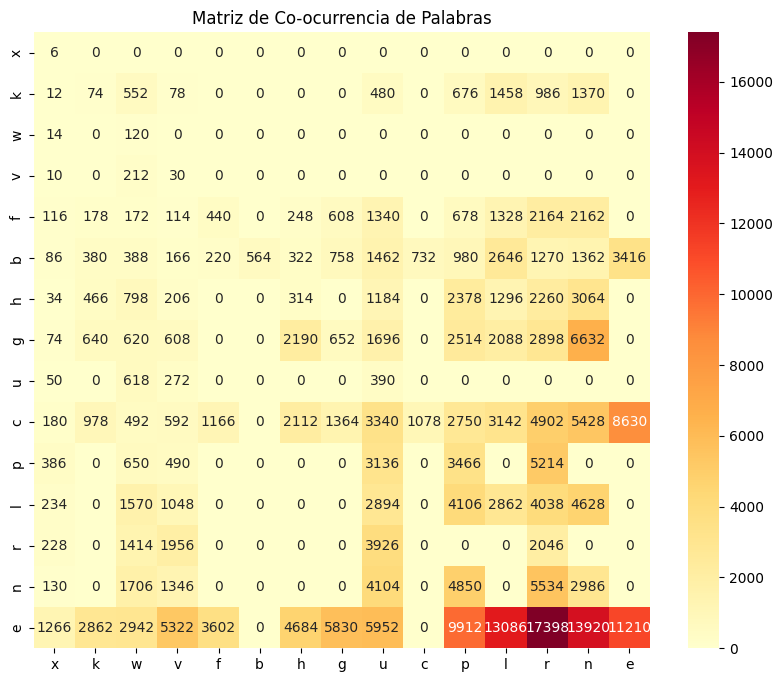

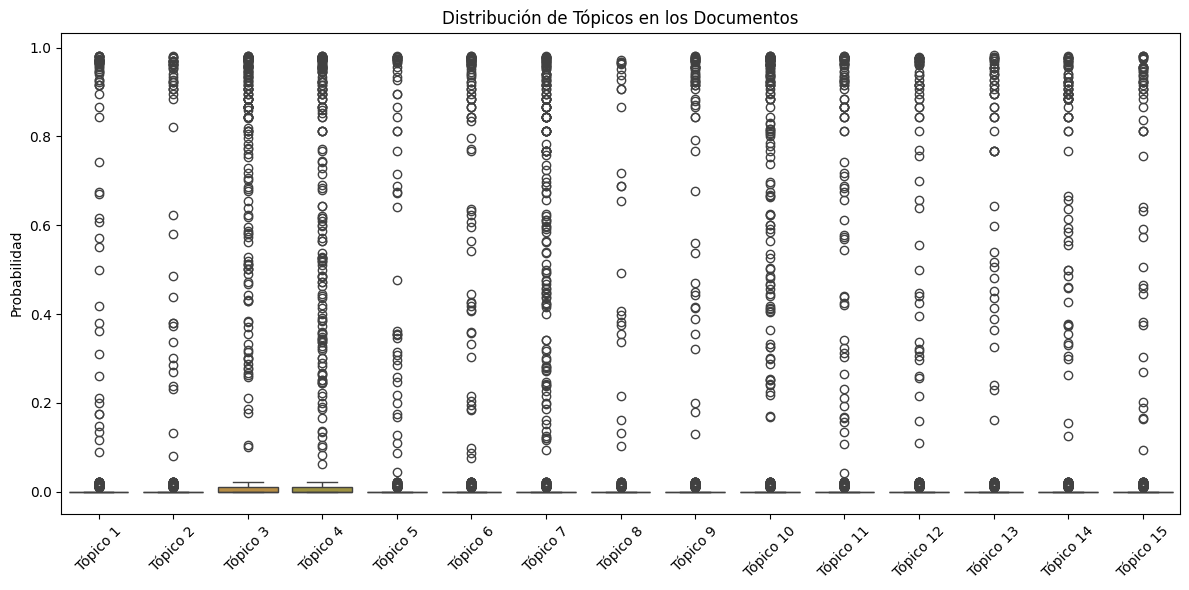

In [29]:
clusterer = LDACoOccurrenceClusterer(num_topics=15) # Experimentar con diferentes números de tópicos x
clusterer.fit(data_words)

print("\nTópicos encontrados:")
for i, topic in enumerate(clusterer.get_topics()):
    print(f"Tópico {i+1}: {', '.join(topic)}")

print("\nGenerando visualizaciones...")
clusterer.visualize_co_occurrence(top_n=15) # Increased top_n for better visualization
clusterer.visualize_topic_distribution(data_words)

AL hacer multiples intentos, se logra evidenciar que con la grafica de boxplots es posible evidenciar la probabilidad de los topicos distribuida en todos los documentos. Dando la idera de aquellos topicos mas pprevalentes en el dataset.

Con un numero alto de clusters, no es posible identificar un patron.
En este caso una cantidad de 5 es optima. reflejando los topicos mas prevalentes.

en ese caso los mas probables son:
Tópicos encontrados con num_topics=5:

Tópico 1: app, get, like, time, order

Tópico 3: app, good, buy, shipping, one

Tópico 5: app, products, like, alibaba, good

Ej. si se quiere hace un modelo predictivo de X enfermedad con redes sociales, se realizaria un LDA en lo que escriben los pacientes, detectando grupos de palabras que son mas predominantes. teniendo esos grupos de palabras, se entrenaria un modelo de prediccion que me prediga
enfermedad ~ topico (palabras)